### Ячейка 1: Импорты и глобальные настройки

Собираем все необходимое в одном месте: библиотеки, константы и настройки для графиков.

In [82]:
# --- Системные и основные библиотеки ---
import os
import warnings
import pandas as pd
import numpy as np

# --- Визуализация ---
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

# --- Машинное обучение (Scikit-learn) ---
from sklearn.model_selection import train_test_split

# --- Машинное обучение (PyTorch) ---
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# --- Игнорируем предупреждения для чистоты вывода ---
warnings.filterwarnings('ignore')

# --- Константы ---
DATA_PATH = "data"
FILE_TRAIN = os.path.join(DATA_PATH, "train.csv")
FILE_TEST = os.path.join(DATA_PATH, "test.csv")
SUBMISSION_FILE = 'submission_house_prices.csv'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Настройки для визуализации ---
plt.style.use('ggplot')
rcParams['figure.figsize'] = 12, 8

print(f"Все библиотеки импортированы.")
print(f"Обучение будет производиться на устройстве: {DEVICE}")

Все библиотеки импортированы.
Обучение будет производиться на устройстве: cuda


### Ячейка 2: Загрузка данных

Загружаем данные и сразу создаем копию тестового набора для будущего файла с предсказаниями.

In [83]:
# Загрузка данных
try:
    df_train = pd.read_csv(FILE_TRAIN)
    df_test = pd.read_csv(FILE_TEST)
    
    # Сохраняем оригинальный тестовый набор для финального файла
    # Он понадобится нам для извлечения Id
    df_test_original = df_test.copy()

    print("Данные успешно загружены.")
    print(f"Размер обучающего набора (train): {df_train.shape}")
    print(f"Размер тестового набора (test):   {df_test.shape}")
    
except FileNotFoundError:
    print(f"Ошибка: Файлы не найдены в директории '{DATA_PATH}'. Убедитесь, что путь указан верно.")

Данные успешно загружены.
Размер обучающего набора (train): (1460, 81)
Размер тестового набора (test):   (1459, 80)


### Ячейка 3: Стратегия обработки данных (Feature Engineering)

На этом этапе мы превращаем "сырые" данные в качественные признаки для нашей модели. Ваш анализ был очень точным, и мы реализуем его ключевые идеи:

1.  **Заполнение пропусков:** Простые числовые пропуски (например, площадь) заполним нулями, предполагая, что пропуск означает отсутствие данного элемента (нет гаража — нет площади).
2.  **Преобразование порядковых признаков:** Категории, имеющие четкий порядок (например, качество отделки от "Плохо" до "Отлично"), переведем в числа (от 1 до 5). Это позволит модели понять их иерархию.
3.  **Создание новых признаков (Feature Engineering):** Извлечем максимум информации из сложных столбцов. Например:
    *   Из `HouseStyle` создадим признаки `Количество этажей` и `Тип отделки`.
    *   `Condition1` и `Condition2` объединим в признаки `Близость к дороге`, `Близость к Ж/Д` и т.д.
    *   `Utilities` (коммуникации) разобьем на бинарные флаги: `Есть газ`, `Есть вода` и т.д.
4.  **Кодирование номинальных признаков:** Категории, не имеющие порядка (например, `Район`), преобразуем с помощью **One-Hot Encoding**. Это создаст новые бинарные столбцы для каждой категории.
5.  **Нормализация дат:** Признаки, связанные с годом (`YearBuilt`, `YrSold`), приведем к единому формату — "сколько лет/месяцев прошло до определенной даты". Это сделает их более понятными для модели.

Этот комплексный подход позволит нам подготовить данные наилучшим образом.

### Ячейка 4: Функции-помощники для обработки признаков

Чтобы сделать основной код чище, мы вынесем всю логику преобразований в отдельные функции. Это также позволит легко переиспользовать их.


In [84]:
print("Шаг 1: Выполнение базовой предобработки...")

# Создаем рабочие копии датафреймов
df_train_proc = df_train.copy()
df_test_proc = df_test.copy()

# --- Заполнение пропущенных числовых значений нулями (из блока 3) ---
numeric_cols_to_fill = [
    'LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 
    'TotalBsmtSF', 'BsmtUnfSF', 'BsmtFullBath', 'BsmtHalfBath', 
    'GarageCars', 'GarageArea'
]
for col in numeric_cols_to_fill:
    if col in df_train_proc.columns:
        df_train_proc[col].fillna(0, inplace=True)
    if col in df_test_proc.columns:
        df_test_proc[col].fillna(0, inplace=True)

# --- Преобразование порядковых признаков в числовые (из блоков 4.2 и 4.3) ---
ordinal_maps = {
    'ExterQual':  {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}, 'ExterCond':  {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},
    'BsmtQual':   {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}, 'BsmtCond':   {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},
    'HeatingQC':  {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}, 'KitchenQual':{'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},
    'FireplaceQu':{'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}, 'GarageQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},
    'GarageCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}, 'PoolQC':     {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},
    'BsmtExposure': {'Gd': 3, 'Av': 2, 'Mn': 1, 'No': 0},
    'Functional': {'Typ': 0, 'Min1': 1, 'Min2': 2, 'Mod': 3, 'Maj1': 4, 'Maj2': 5, 'Sev': 6, 'Sal': 7},
    'LotShape':   {'Reg': 0, 'IR1': 1, 'IR2': 2, 'IR3': 3}, 'LandSlope':  {'Gtl': 0, 'Mod': 1, 'Sev': 2},
    'GarageFinish': {'Fin': 3, 'RFn': 2, 'Unf': 1}, 'PavedDrive': {'Y': 2, 'P': 1, 'N': 0}
}
for col, mapping in ordinal_maps.items():
    if col in df_train_proc.columns:
        df_train_proc[col] = df_train_proc[col].map(mapping).fillna(0).astype(int)
    if col in df_test_proc.columns:
        df_test_proc[col] = df_test_proc[col].map(mapping).fillna(0).astype(int)

# --- Нормализация дат (из блока 4.3) ---
for df in [df_train_proc, df_test_proc]:
    if 'YearBuilt' in df.columns: df['YearBuilt'] = 2011 - df['YearBuilt']
    if 'YearRemodAdd' in df.columns: df['YearRemodAdd'] = 2011 - df['YearRemodAdd']
    if 'MoSold' in df.columns and 'YrSold' in df.columns:
        df['MonthsSoldAgo'] = (12 - df['MoSold']) + (2010 - df['YrSold']) * 12
        df.drop(['MoSold', 'YrSold'], axis=1, inplace=True, errors='ignore')

print("Базовая предобработка завершена.")

Шаг 1: Выполнение базовой предобработки...
Базовая предобработка завершена.



### Ячейка 5: Единый пайплайн обработки данных

Теперь применим все наши функции в правильном порядке. Это сердце нашего pre-processing'а.

In [85]:
print("\nШаг 2: Выполнение Feature Engineering (создание новых признаков)...")

# --- Garage Features ---
# Сначала считаем медиану на обучающем наборе
median_year_from_train = df_train_proc.loc[df_train_proc['GarageYrBlt'].notna(), 'GarageYrBlt'].median()

for df in [df_train_proc, df_test_proc]:
    # Создаем Num_Garages
    if 'GarageType' in df.columns:
        df['Num_Garages'] = 0
        garage_type_filled = df['GarageType'].fillna('NoGarage')
        misc_feature_filled = df['MiscFeature'].fillna('NoMisc')
        single_garage_types = ['Attchd', 'Basment', 'BuiltIn', 'CarPort', 'Detchd']
        df.loc[garage_type_filled.isin(single_garage_types), 'Num_Garages'] = 1
        df.loc[garage_type_filled == '2Types', 'Num_Garages'] = 2
        df.loc[misc_feature_filled == 'Gar2', 'Num_Garages'] += 1
    # Обрабатываем GarageYrBlt
    if 'GarageYrBlt' in df.columns:
        df['GarageYrBlt'].fillna(median_year_from_train, inplace=True)
        df['GarageYrBlt_Age'] = 2011 - df['GarageYrBlt'].astype(int)
        df.drop('GarageYrBlt', axis=1, inplace=True)

# --- House Style Features ---
for df in [df_train_proc, df_test_proc]:
    if 'HouseStyle' in df.columns:
        floor_mapping = {'1Story': 1.0, '1.5Fin': 1.5, '1.5Unf': 1.5, '2Story': 2.0, '2.5Fin': 2.5, '2.5Unf': 2.5, 'SFoyer': 2.0, 'SLvl': 2.0}
        df['Num_Floors'] = df['HouseStyle'].map(floor_mapping).fillna(1.0)
        df['Is_SFoyer'] = (df['HouseStyle'] == 'SFoyer').astype(int)
        df['Is_SLvl'] = (df['HouseStyle'] == 'SLvl').astype(int)
        df['Is_Upper_Unfinished'] = df['HouseStyle'].str.contains('Unf', na=False).astype(int)
        df.drop('HouseStyle', axis=1, inplace=True)

# --- Basement Finish Features ---
for df in [df_train_proc, df_test_proc]:
    if 'BsmtFinType1' in df.columns:
        quality_map = {'GLQ': 5, 'ALQ': 4, 'BLQ': 3, 'LwQ': 2, 'Unf': 1, 'NA': 0}
        for i in [1, 2]:
            type_col = f'BsmtFinType{i}'
            if type_col in df.columns:
                df[f'Is_Rec_Room{i}'] = (df[type_col] == 'Rec').astype(int)
                temp_scores = df[type_col].map(quality_map)
                median_for_rec = temp_scores.median()
                df[f'BsmtFinQuality{i}'] = temp_scores
                df.loc[df[type_col] == 'Rec', f'BsmtFinQuality{i}'] = median_for_rec
                df[f'BsmtFinQuality{i}'] = df[f'BsmtFinQuality{i}'].fillna(0).astype(int)
                df.drop(type_col, axis=1, inplace=True)

# --- Location Features ---
def map_condition(cond_series, level1, level2):
    levels = pd.Series(0, index=cond_series.index)
    levels[cond_series.isin(level1)] = 1
    levels[cond_series.isin(level2)] = 2
    return levels

for df in [df_train_proc, df_test_proc]:
    if 'Condition1' in df.columns:
        street_l1, street_l2 = {'Feedr'}, {'Artery'}
        rail_l1, rail_l2 = {'RRNn', 'RRNe'}, {'RRAn', 'RRAe'}
        pos_l1, pos_l2 = {'PosN'}, {'PosA'}
        df['StreetProximity'] = np.maximum(map_condition(df['Condition1'], street_l1, street_l2), map_condition(df['Condition2'], street_l1, street_l2))
        df['RailProximity'] = np.maximum(map_condition(df['Condition1'], rail_l1, rail_l2), map_condition(df['Condition2'], rail_l1, rail_l2))
        df['PositiveFeature'] = np.maximum(map_condition(df['Condition1'], pos_l1, pos_l2), map_condition(df['Condition2'], pos_l1, pos_l2))
        df.drop(['Condition1', 'Condition2'], axis=1, inplace=True, errors='ignore')

# --- И другие ваши функции из 4.4, если они были ---
# Я добавлю остальные из вашего скрипта для полноты
for df in [df_train_proc, df_test_proc]:
    # Exterior material
    ALL_EXTERIOR_MATERIALS = ['AsbShng', 'AsphShn', 'BrkComm', 'BrkFace', 'CBlock', 'CemntBd', 'HdBoard', 'ImStucc', 'MetalSd', 'Other', 'Plywood', 'Stone', 'Stucco', 'VinylSd', 'Wd Sdng', 'WdShing']
    for mat in ALL_EXTERIOR_MATERIALS:
        col_name = f'ExtMat_{mat.replace(" ", "_")}'
        is_in_ext1 = (df['Exterior1st'] == mat) if 'Exterior1st' in df.columns else False
        is_in_ext2 = (df['Exterior2nd'] == mat) if 'Exterior2nd' in df.columns else False
        df[col_name] = (is_in_ext1 | is_in_ext2).astype(int)
    df.drop(['Exterior1st', 'Exterior2nd'], axis=1, inplace=True, errors='ignore')
    
    # Utilities
    if 'Utilities' in df.columns:
        df['Has_AllPub'] = (df['Utilities'] == 'AllPub').astype(int)
        df['Has_NoSewr'] = (df['Utilities'] == 'NoSewr').astype(int)
        df.drop('Utilities', axis=1, inplace=True, errors='ignore')
        
    # Electrical
    if 'Electrical' in df.columns:
        romex_map = {'SBrkr': 2, 'FuseA': 2, 'FuseF': 1, 'Mix': 1, 'FuseP': 0}
        df['RomexWiring_Level'] = df['Electrical'].map(romex_map).fillna(0).astype(int)
        df['Is_MixedSystem'] = (df['Electrical'] == 'Mix').astype(int)
        df['Is_SBrkr'] = (df['Electrical'] == 'SBrkr').astype(int)
        df.drop('Electrical', axis=1, inplace=True, errors='ignore')

    # Fence
    if 'Fence' in df.columns:
        df['Privacy_Level'] = df['Fence'].map({'GdPrv': 2, 'MnPrv': 1}).fillna(0).astype(int)
        df['Wood_Fence_Level'] = df['Fence'].map({'GdWo': 2, 'MnWw': 1}).fillna(0).astype(int)
        df.drop('Fence', axis=1, inplace=True, errors='ignore')

print("Создание новых признаков завершено.")
print(df_test_proc)


Шаг 2: Выполнение Feature Engineering (создание новых признаков)...
Создание новых признаков завершено.
        Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley  LotShape  \
0     1461          20       RH         80.0    11622   Pave   NaN         0   
1     1462          20       RL         81.0    14267   Pave   NaN         1   
2     1463          60       RL         74.0    13830   Pave   NaN         1   
3     1464          60       RL         78.0     9978   Pave   NaN         1   
4     1465         120       RL         43.0     5005   Pave   NaN         1   
...    ...         ...      ...          ...      ...    ...   ...       ...   
1454  2915         160       RM         21.0     1936   Pave   NaN         0   
1455  2916         160       RM         21.0     1894   Pave   NaN         0   
1456  2917          20       RL        160.0    20000   Pave   NaN         0   
1457  2918          85       RL         62.0    10441   Pave   NaN         0   
1458  2919     

### Ячейка 6: One-Hot Encoding и выравнивание столбцов

На этом шаге мы преобразуем оставшиеся категориальные признаки в числовой формат и гарантируем, что в обучающем и тестовом наборах будет одинаковый набор столбцов.

In [86]:
print("\nШаг 3: Финальная обработка и One-Hot Encoding...")

# --- Удаление ненужных столбцов ---
cols_to_drop = ['Id', 'MSSubClass', 'TotalBsmtSF']
df_train_proc.drop(columns=cols_to_drop, inplace=True, errors='ignore')
df_test_proc.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# --- Определяем категориальные признаки (ВАШ ОРИГИНАЛЬНЫЙ СПИСОК из блока 4.4) ---
categorical_features = [
    'MSZoning', 'Street', 'Alley', 'LandContour',
    'LotConfig', 'Neighborhood',  
    'BldgType', 'RoofStyle', 'RoofMatl',
    'MasVnrType', 'Foundation', 
    'Heating', 'CentralAir', 'GarageType',  
    'MiscFeature', 'SaleType', 'SaleCondition'
]
# Убедимся, что в списке только те колонки, что еще есть в датафрейме
categorical_features = [col for col in categorical_features if col in df_train_proc.columns]

print(f"\nРазмер до One-Hot Encoding:")
print(f"Train: {df_train_proc.shape}, Test: {df_test_proc.shape}")
print(f"Количество признаков для OHE: {len(categorical_features)}")

# --- One-Hot Encoding ---
df_train_ohe = pd.get_dummies(df_train_proc, columns=categorical_features, drop_first=True, dtype=int)
df_test_ohe = pd.get_dummies(df_test_proc, columns=categorical_features, drop_first=True, dtype=int)

# --- Выравнивание столбцов ---
train_cols = df_train_ohe.drop('SalePrice', axis=1, errors='ignore').columns
df_test_final = df_test_ohe.reindex(columns=train_cols, fill_value=0)

print(f"\nРазмер после OHE и выравнивания:")
print(f"Train: {df_train_ohe.shape}, Test: {df_test_final.shape}")
print(f"Финальное количество признаков для модели: {df_test_final.shape[1]}")


Шаг 3: Финальная обработка и One-Hot Encoding...

Размер до One-Hot Encoding:
Train: (1460, 102), Test: (1459, 101)
Количество признаков для OHE: 17

Размер после OHE и выравнивания:
Train: (1460, 172), Test: (1459, 171)
Финальное количество признаков для модели: 171


### Ячейка 7: Подготовка данных для обучения

Разделяем данные на признаки (X) и цель (y), логарифмируем целевую переменную и делим выборку на обучающую и валидационную.

In [87]:
# Разделение на признаки и целевую переменную
X = df_train_ohe.drop(TARGET_COL, axis=1)
y = df_train_ohe[TARGET_COL]

# Логарифмируем целевую переменную
# Используем log1p, который вычисляет log(1+x), чтобы избежать проблем с нулевыми ценами
y_log = np.log1p(y)

# Разделение на обучающую и валидационную выборки
X_train, X_val, y_train_log, y_val_log = train_test_split(
    X, y_log, 
    test_size=0.2, 
    random_state=42
)

print("Данные разделены на обучающую и валидационную выборки.")
print(f"X_train: {X_train.shape}, y_train: {y_train_log.shape}")
print(f"X_val:   {X_val.shape}, y_val:   {y_val_log.shape}")

Данные разделены на обучающую и валидационную выборки.
X_train: (1168, 171), y_train: (1168,)
X_val:   (292, 171), y_val:   (292,)



### Ячейка 8: Создание PyTorch Tensors и DataLoaders

Преобразуем наши `pandas.DataFrame` в `torch.Tensor` и упаковываем их в `DataLoader`. `DataLoader` позволяет подавать данные в модель батчами (небольшими порциями), что эффективно использует память и улучшает обучение.

In [88]:
# Преобразование в тензоры PyTorch
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_log.values, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_log.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(df_test_final.values, dtype=torch.float32)

# Создание кастомного Dataset
class HousesDataset(Dataset):
    """Класс для удобной работы с данными о домах в PyTorch."""
    def __init__(self, features, labels=None):
        self.features = features
        self.labels = labels
        self.is_test = labels is None
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        if self.is_test:
            return self.features[idx]
        else:
            return self.features[idx], self.labels[idx]

# Создание DataLoaders
BATCH_SIZE = 128
train_loader = DataLoader(dataset=HousesDataset(X_train_tensor, y_train_tensor), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=HousesDataset(X_val_tensor, y_val_tensor), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=HousesDataset(X_test_tensor), batch_size=BATCH_SIZE, shuffle=False)

print("Тензоры и DataLoaders созданы.")
print(f"Размер батча: {BATCH_SIZE}")

Тензоры и DataLoaders созданы.
Размер батча: 128



### Ячейка 9: Определение архитектуры нейронной сети

Здесь мы описываем нашу модель. Выбранная вами архитектура очень хороша для табличных данных.

*   **`BatchNorm1d` (пакетная нормализация):** Стабилизирует и ускоряет обучение, нормализуя выходы предыдущего слоя. Также работает как легкая форма регуляризации.
*   **`GELU` (Gaussian Error Linear Unit):** Современная функция активации, часто показывающая результаты лучше, чем классическая `ReLU`.
*   **`Dropout`:** "Выключает" случайные нейроны на каждом шаге обучения. Это мощный метод борьбы с переобучением, заставляющий сеть не полагаться на какой-то один признак.
*   **`Linear`:** Обычный полносвязный слой.

In [89]:
class DeepRegressionModel(nn.Module):
    """Глубокая нейронная сеть для задачи регрессии."""
    
    def __init__(self, num_features):
        super().__init__()
        
        self.layers = nn.Sequential(
            nn.BatchNorm1d(num_features),
            nn.Linear(num_features, num_features),
            nn.GELU(),
            nn.Dropout(0.4),
            
            nn.BatchNorm1d(num_features),
            nn.Linear(num_features, 64),
            nn.GELU(),
            nn.Dropout(0.4),
            
            nn.BatchNorm1d(64),
            nn.Linear(64, 1) # Выходной слой: 1 нейрон для предсказания цены
        )

    def forward(self, x):
        return self.layers(x)

# --- Инициализация модели ---
input_features = X_train.shape[1]
model = DeepRegressionModel(input_features).to(DEVICE)

print("Архитектура модели:")
print(model)

Архитектура модели:
DeepRegressionModel(
  (layers): Sequential(
    (0): BatchNorm1d(171, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=171, out_features=171, bias=True)
    (2): GELU(approximate='none')
    (3): Dropout(p=0.4, inplace=False)
    (4): BatchNorm1d(171, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Linear(in_features=171, out_features=64, bias=True)
    (6): GELU(approximate='none')
    (7): Dropout(p=0.4, inplace=False)
    (8): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
)



### Ячейка 10: Настройка процесса обучения

Определяем "правила игры" для обучения: функцию потерь, оптимизатор и планировщик скорости обучения.

*   **Функция потерь (`MSELoss`):** Среднеквадратичная ошибка. Идеально подходит для регрессии, так как сильно штрафует за большие ошибки.
*   **Оптимизатор (`RAdam`):** Улучшенная версия популярного оптимизатора Adam. Он эффективно подбирает веса модели, чтобы минимизировать функцию потерь.
*   **Планировщик (`ReduceLROnPlateau`):** Автоматически снижает скорость обучения (`learning rate`), если ошибка на валидации перестает улучшаться. Это помогает модели "тонко настроиться" на финальных этапах.

In [90]:
# --- Гиперпараметры обучения ---
NUM_EPOCHS = 400
LEARNING_RATE = 0.004
WEIGHT_DECAY = 0.01 # L2-регуляризация в оптимизаторе

# --- Настройка ---
criterion = nn.MSELoss()
optimizer = torch.optim.RAdam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=40)

print("Настройки обучения определены:")
print(f"Эпохи: {NUM_EPOCHS}, Скорость обучения: {LEARNING_RATE}")

Настройки обучения определены:
Эпохи: 400, Скорость обучения: 0.004


### Ячейка 11: Цикл обучения модели

Запускаем главный цикл, где модель будет итеративно учиться на данных, а мы — следить за ее прогрессом.

In [91]:
train_losses = []
val_losses = []

print(f"Начинаем обучение на {NUM_EPOCHS} эпох...")

for epoch in range(NUM_EPOCHS):
    # --- Фаза обучения ---
    model.train()
    current_train_loss = 0.0
    for features, labels in train_loader:
        features, labels = features.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        current_train_loss += loss.item() * features.size(0)
    
    epoch_train_loss = np.sqrt(current_train_loss / len(train_loader.dataset)) # RMSE
    train_losses.append(epoch_train_loss)
    
    # --- Фаза валидации ---
    model.eval()
    current_val_loss = 0.0
    with torch.no_grad():
        for features, labels in val_loader:
            features, labels = features.to(DEVICE), labels.to(DEVICE)
            outputs = model(features)
            loss = criterion(outputs, labels)
            current_val_loss += loss.item() * features.size(0)
    
    epoch_val_loss = np.sqrt(current_val_loss / len(val_loader.dataset)) # RMSE
    val_losses.append(epoch_val_loss)
    
    # Обновление планировщика
    scheduler.step(epoch_val_loss)
    
    # Вывод прогресса
    if (epoch + 1) % 20 == 0 or epoch == 0:
        print(f"Эпоха [{epoch+1:03}/{NUM_EPOCHS}] | "
              f"Train RMSE: {epoch_train_loss:.4f} | "
              f"Val RMSE: {epoch_val_loss:.4f} | "
              f"LR: {optimizer.param_groups[0]['lr']:.6f}")

print("\nОбучение завершено!")

Начинаем обучение на 400 эпох...
Эпоха [001/400] | Train RMSE: 11.6488 | Val RMSE: 11.3536 | LR: 0.004000
Эпоха [020/400] | Train RMSE: 7.2891 | Val RMSE: 6.6863 | LR: 0.004000
Эпоха [040/400] | Train RMSE: 1.4884 | Val RMSE: 0.4320 | LR: 0.004000
Эпоха [060/400] | Train RMSE: 0.9487 | Val RMSE: 0.2502 | LR: 0.004000
Эпоха [080/400] | Train RMSE: 0.6836 | Val RMSE: 0.1978 | LR: 0.004000
Эпоха [100/400] | Train RMSE: 0.3563 | Val RMSE: 0.1760 | LR: 0.004000
Эпоха [120/400] | Train RMSE: 0.2318 | Val RMSE: 0.1681 | LR: 0.004000
Эпоха [140/400] | Train RMSE: 0.1664 | Val RMSE: 0.1496 | LR: 0.004000
Эпоха [160/400] | Train RMSE: 0.1475 | Val RMSE: 0.1477 | LR: 0.004000
Эпоха [180/400] | Train RMSE: 0.1439 | Val RMSE: 0.1424 | LR: 0.004000
Эпоха [200/400] | Train RMSE: 0.1406 | Val RMSE: 0.1438 | LR: 0.004000
Эпоха [220/400] | Train RMSE: 0.1386 | Val RMSE: 0.1550 | LR: 0.004000
Эпоха [240/400] | Train RMSE: 0.1418 | Val RMSE: 0.1443 | LR: 0.004000
Эпоха [260/400] | Train RMSE: 0.1377 | Val

### Ячейка 12: Визуализация результатов обучения

График потерь — лучший способ понять, как прошло обучение. Мы ищем момент, когда обе кривые (train и validation) выходят на плато, и при этом кривая валидации не начинает расти (это было бы признаком переобучения).

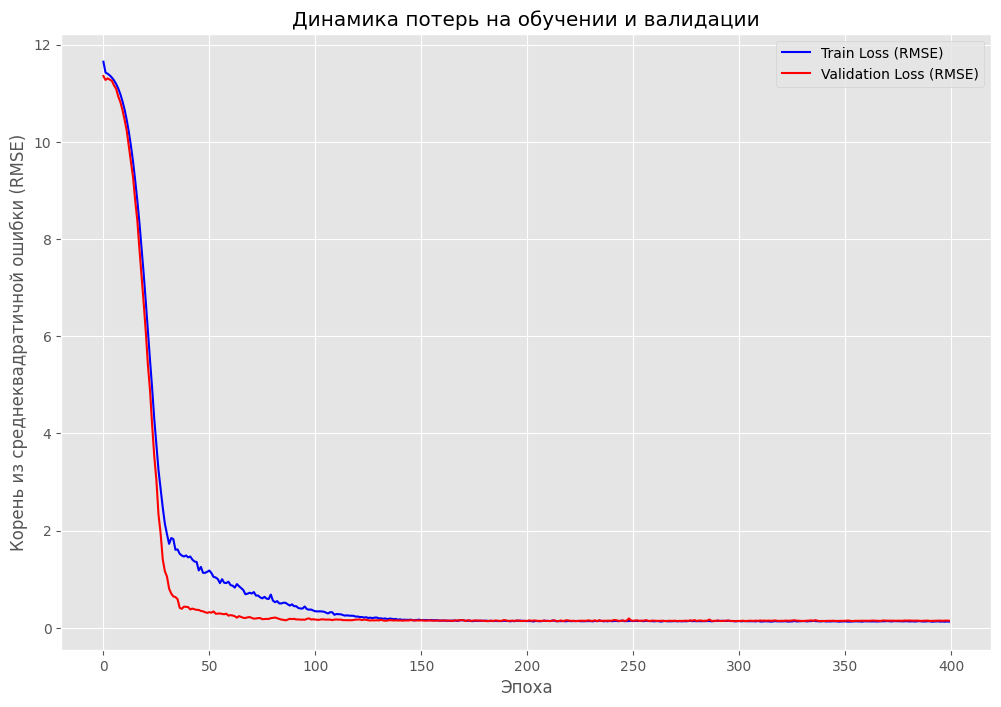

In [92]:
plt.figure(figsize=(12, 8))
plt.plot(train_losses, label='Train Loss (RMSE)', color='blue')
plt.plot(val_losses, label='Validation Loss (RMSE)', color='red')
plt.xlabel('Эпоха')
plt.ylabel('Корень из среднеквадратичной ошибки (RMSE)')
plt.title('Динамика потерь на обучении и валидации')
plt.legend()
plt.grid(True)
plt.show()

### Ячейка 13: Создание файла для отправки на Kaggle

Последний шаг: генерируем предсказания для тестового набора, возвращаем их из логарифмического масштаба в реальные цены и сохраняем в `csv`-файл в нужном формате.

In [93]:
# Ячейка 13: Создание файла для отправки на Kaggle (Финальная версия)

model.eval()
all_predictions = []

with torch.no_grad():
    for features_batch in test_loader:
        features_batch = features_batch.to(DEVICE)
        outputs = model(features_batch)
        predicted_prices = torch.expm1(outputs)
        all_predictions.extend(predicted_prices.cpu().numpy().flatten().tolist())

print(f"Предсказания для {len(all_predictions)} тестовых примеров сгенерированы.")

# --- Создание submission файла ---
submission_df = pd.DataFrame({
    'Id': df_test_original['Id'],
    'SalePrice': all_predictions
})

# Сохраняем файл БЕЗ ИНДЕКСА
submission_df.to_csv(SUBMISSION_FILE, index=False)

print(f"\nSubmission файл '{SUBMISSION_FILE}' успешно создан.")
print("Первые 5 строк submission файла:")
print(submission_df.head())

Предсказания для 1459 тестовых примеров сгенерированы.

Submission файл 'submission_house_prices.csv' успешно создан.
Первые 5 строк submission файла:
     Id      SalePrice
0  1461  103709.570312
1  1462  126502.218750
2  1463  147224.140625
3  1464  162822.562500
4  1465  175423.421875
